# Modeling Relationships

In this chapter, we'll explore how to build complex relationships between entities using a combination of uniqueness constraints and referential constraints. Understanding these patterns is essential for designing schemas that accurately represent business rules and data dependencies.

## Uniqueness Constraints

Uniqueness constraints are typically set through primary keys, but tables can also have additional unique indexes beyond the primary key. These constraints ensure that specific combinations of attributes remain unique across all rows in a table.

## Referential Constraints

Referential constraints establish relationships between tables and are enforced by [foreign keys](030-foreign-keys.ipynb). They ensure that references between tables remain valid and prevent orphaned records.

## Foreign Keys Establish 1:N or 1:1 Relationships

When a child table defines a foreign key constraint to a parent table, it creates a relationship between the entities in the parent and child tables. The cardinality of this relationship is always **1 on the parent side**: each entry in the child table must refer to a single entity in the parent table.

On the child side, the relationship can have different cardinalities:

- **0–1 (optional one-to-one)**: if the foreign key field in the child table has a unique constraint
- **1 (mandatory one-to-one)**: if the foreign key is the entire primary key of the child table
- **N (one-to-many)**: if no uniqueness constraint is applied to the foreign key field

## What We'll Cover

This chapter explores these key relationship patterns:

* **One-to-Many Relationships**: The most common pattern, using foreign keys in secondary attributes
* **One-to-One Relationships**: Using primary key foreign keys or unique constraints
* **Many-to-Many Relationships**: Using association tables with composite primary keys
* **Sequences**: Cascading one-to-one relationships for workflows
* **Hierarchies**: Cascading one-to-many relationships for nested data structures
* **Parameterization**: Association tables where the association itself is the primary entity
* **Directed Graphs**: Self-referencing relationships with renamed foreign keys
* **Complex Constraints**: Using nullable enums with unique indexes for special requirements

Let's begin by illustrating these possibilities with examples of bank customers and their accounts.

In [1]:
import datajoint as dj

# One-to-Many Relationships

In the first example, let the rule be that customers are independent entities and accounts have exactly one owner but customers can have any number of accounts.
This is an example of an 1:N relationship between customers and their accounts.

Then the foreign key is declared in the `Account` table.

[2025-10-08 14:27:33,185][INFO]: DataJoint 0.14.6 connected to dev@db:3306


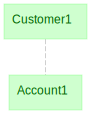

In [2]:
schema1 = dj.Schema('bank1')
@schema1
class Customer1(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned
    unique index(ssn)
    """

@schema1
class Account1(dj.Manual):
    definition = """
    account : int unsigned
    ---
    -> Customer1
    open_date : date
    """

dj.Diagram(schema1)

In this design:

* Each account is linked to a single customer through a foreign key referencing the primary key in Customer1, ensuring that each account has one, and only one, owner.
* This setup allows each customer to own multiple accounts, as there is no unique constraint on the foreign key in Account1.
* Customers may have zero or more accounts, as there’s no requirement for every customer to have an associated account.
* Every account must have an owner, since the foreign key reference to Customer1 is mandatory (non-nullable).

This structure establishes a one-to-many relationship between customers and accounts: one customer can own multiple accounts, but each account belongs to only one customer.

To allow some accounts without an assigned owner, we can modify the design to make the foreign key nullable:

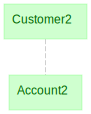

In [3]:
schema2 = dj.Schema('bank2')
@schema2
class Customer2(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned
    unique index(ssn)
    """

@schema2
class Account2(dj.Manual):
    definition = """
    account : int unsigned
    ---
    -> [nullable] Customer2
    open_date : date
    """

dj.Diagram(schema2)

In this modified design:

* Accounts without owners are allowed by setting the foreign key to Customer2 as nullable.
* The schema diagram does not visually distinguish between required and optional dependencies, so the nullable nature of the foreign key is not visible in the diagram.
* This configuration supports cases where accounts may or may not be assigned to a customer, adding flexibility to the data model.

Consider a third design where the foreign key is part of a composite primary key:

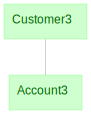

In [4]:
schema3 = dj.Schema('bank3')

@schema3
class Customer3(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    """

@schema3
class Account3(dj.Manual):
    definition = """
    -> Customer3
    account : int unsigned
    ---
    open_date : date
    """

dj.Diagram(schema3)

In this design:

* Composite Primary Key: The primary key for `Account3` is a combination of `customer_id` and `account`, meaning each account is uniquely identified by both the customer and account number together and neither of the two fields separately has to be unique across accounts.
* One-to-Many Relationship: Since `customer_id` is only part of the primary key (not the entire primary key), it doesn’t need to be unique within `Account3`. This allows each customer to have multiple accounts, preserving the one-to-many relationship between Customer3 and Account3.
* Foreign Key Reference: The foreign key to `Customer3` establishes the relationship, ensuring that each entry in Account3 references a valid customer in Customer3.

This setup maintains the one-to-many relationship while allowing for each account to be uniquely identified by a combination of customer and account identifiers.

In the diagram, solid lines indicate a dependency where the foreign key is part of the primary key, signifying a stronger relationship than a secondary reference. This stronger relationship ensures that any foreign keys pointing to `Account3` will also transitively reference `Customer3`.

### Exercise: Analyzing Bank Design

Review the database design below and consider how this structure might reflect the bank’s operations.

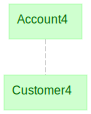

In [5]:
schema4 = dj.Schema('bank4')

@schema4
class Account4(dj.Manual):
    definition = """
    account : int unsigned
    ---
    open_date : date
    """


@schema4
class Customer4(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    -> Account4
    """


dj.Diagram(schema4)

### Interpretation
Consider the implications of this setup:

* Each customer entry contains a reference to a single account in `Account4`, suggesting that each customer is linked to one specific account.
* Since there is no constraint on the number of customers who can point to the same account, this design may allow multiple customers to be associated with a single account, indicating the possibility of shared accounts.
* However, the structure does not allow an customer to exist without being associated with an account, as each customer record must reference an existing account.

These choices might reflect the bank’s operations and policies, such as whether joint accounts are supported, and how account ownership is managed.

# One-to-One Relationships

A one-to-one relationship is created when a foreign key in the child table is also designated as either the primary key or a unique index. This ensures that each entry in the child table corresponds to a single, unique entry in the parent table, and no parent entry is linked to more than one child entry.

In a one-to-one relationship, the connection is always optional on the child side: a child entry is not required for every parent entry. Therefore, the cardinality on the child side is 0..1—each parent may have either zero or one associated child entry.

In the following example, the foreign key in `Account` is also its primary key, resulting in a one-to-one relationship:

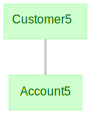

In [6]:
schema5 = dj.Schema('bank5')

@schema5
class Customer5(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    """

@schema5
class Account5(dj.Manual):
    definition = """
    -> Customer5
    ---
    open_date : date
    """

dj.Diagram(schema5)

The diagramming notation represents this relationship with a thick solid line, which indicates the strongest type of dependency between two entities.
In this setup, `Customer5` and `Account5` share the same identity because `Account5` inherits its primary key from `Customer5`.
This setup creates a strict one-to-one relationship between Customer5 and Account5, where each account is uniquely and exclusively linked to a single customer.

### Characteristics of This Structure
* **Unified Identity:** Since `Account5` shares the primary key with `Customer5`, each `Account5` record is uniquely identified by the same key as `Customer5`.
This enforces the rule that each account cannot exist without an associated customer.

* **Conflated Entities:** In the diagram, the name `Account5` is no longer underscored, indicating it has ceased to function as a separate “dimension” or independent entity. `Account5` is now fully conflated with `Customer5`, meaning it effectively serves as an extension of the `Customer5` entity, rather than an independent table with its own identity.

### Why Keep Separate Tables?
Although this design could allow us to simply merge all account-related data into the `Customer5` table, there are reasons we may choose to keep `Account5` as a separate table:

1. **Modularity and Clarity**: Separating `Account5` from `Customer5` keeps the structure modular, which can clarify different aspects of customer and account data in queries and during development.

2. **Data Management**: By keeping account information in a separate table, we can manage and update account-related data independently from customer information. This separation can be beneficial for tasks such as auditing, logging, or updating fields associated with only account data.

3. **Avoiding Optional Fields**: In cases where certain fields are only relevant to accounts (e.g., open_date, account-specific details), keeping them in a separate table prevents having unused or irrelevant fields in the main `Customer5` table.

4. **Access Control**: When account information is sensitive or needs restricted access, placing it in a separate table can simplify access control, allowing finer-grained security policies around account data.

5. **Scalability and Maintenance**: Over time, this separation can support scalability as customer and account data expand. If we anticipate adding extensive account-specific data or if account records will be managed differently from customer records, the separate tables facilitate maintenance and future-proof the structure.

6. **Schema Evolution**: Separate tables provide flexibility to adapt or expand either the Customer5 or Account5 table independently, without altering the other table. This flexibility is especially useful if the schema is expected to evolve over time.

Another approach to establishing a one-to-one relationship is to use a secondary foreign key with an additional uniqueness constraint. DataJoint’s foreign key syntax supports both `unique` and `nullable` modifiers on foreign keys, providing flexibility in how relationships are structured.

* **`unique` Modifier**: Adding the unique modifier to a foreign key converts a one-to-many relationship into a one-to-one relationship. This ensures that each entry in the child table corresponds to only one entry in the parent table and vice versa, enforcing a strict one-to-one link.

* **`nullable` Modifier**: The `nullable` modifier allows the relationship to be optional on the child side, meaning that not every child entry must reference a parent entry. (Relationships are already optional on the parent side, as parent entries don’t depend on children.)

## One-to-One Relationship with Unique and Nullable Modifiers
The following example demonstrates how to model a one-to-one relationship using a secondary unique constraint:

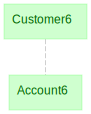

In [7]:

schema6 = dj.Schema('bank6')

@schema6
class Customer6(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    """

@schema6
class Account6(dj.Manual):
    definition = """
    account : int unsigned
    ---
    -> [unique, nullable] Customer6
    open_date : date
    """

dj.Diagram(schema6)

In this design:

* The `Account6` table includes a foreign key reference to `Customer6`, modified with both `unique` and `nullable` modifications.
* The `unique` constraint ensures that each `Account6` entry is exclusively linked to a single `Customer6` entry, establishing a one-to-one relationship.
* The `nullable` constraint allows accounts to exist without necessarily being tied to a customer, making the relationship optional from the child’s perspective.


### When to Use this Approach
Using a secondary unique constraint on a foreign key is helpful when:

* **Optional Relationships**: You want flexibility to create child entries without always requiring a parent reference.
* **Separate, Modular Tables**: Keeping entities modular and maintaining a strict one-to-one relationship without merging the tables or merging the entity identities in the child table with those in the parent.

This method provides flexibility and maintains clear separation between entities while enforcing a one-to-one association, even if the relationship isn’t visually highlighted in the diagram.

## Diagram Representation Limitations

This *dependency-and-constraint* pattern doesn’t visually convey the close, exclusive association created by the unique and nullable modifiers. The diagram will show a basic line for the foreign key, lacking any specific notation to indicate that the relationship is both unique and optional.

The diagram only reflect the relationships formed through the the structure of primary keys and foreign keys, without taking into account the additional constraints imposed by secondary unique indexes. While solid think lines indicate a one-to-one relationship, additional uniqueness constraints may be in force that are not evident from the diagram alone.

Consider all the diagrams side-by-side and recall which ones are one-to-one and which are one-to-many:

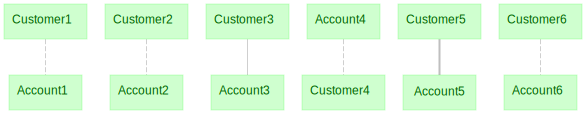

In [8]:
dj.Diagram(schema1) + dj.Diagram(schema2) + dj.Diagram(schema3) + dj.Diagram(schema4) + dj.Diagram(schema5) + dj.Diagram(schema6)

### How to Read Relationships from Diagrams

By examining the diagrams above, only one (`schema5`) clearly shows a one-to-one relationship through its **thick solid line**. Here's how to interpret the diagramming notation:

**Line Styles:**
* **Thick solid line**: One-to-one relationship where the foreign key is the entire primary key of the child table
* **Thin solid line**: One-to-many relationship where the foreign key is part of (but not all of) the primary key 
* **Dashed line**: One-to-many relationship where the foreign key is a secondary attribute (not part of primary key)

**What the Diagram Cannot Show:**
* Whether a foreign key is nullable (allows zero or one instead of exactly one)
* Secondary unique constraints that convert one-to-many into one-to-one
* The diagram only reflects the structure of primary keys and foreign keys

**Pro Tip**: In Jupyter notebooks, you can hover over a diagram element to view its full table definition, including any secondary uniqueness constraints and nullable modifiers.

**Best Practice**: DataJoint users generally avoid secondary unique constraints when the primary key structure can enforce uniqueness. Making the foreign key part of the primary key (creating solid lines in diagrams) provides two benefits:
1. **Visual clarity**: The relationship type is immediately obvious from the diagram
2. **Query simplicity**: Primary keys cascade through foreign keys, enabling direct joins between distant tables in the hierarchy

# Many-to-Many Relationships

In relational databases, a single foreign key between two tables can only establish one-to-many or one-to-one relationships.
To create a many-to-many (M:N) relationship between two entities, a third table is required, with each entry in this table linking one instance from each of the two related tables.
This third table is commonly referred to as an association table or join table.

## Structure of Many-to-Many Relationships
An M:N relationship can be visualized as two one-to-many (1:N and 1:M) relationships with the association table.

The association table contains:
* **A foreign key** referencing each of the two related entities, establishing connections to instances of both tables.
* **Composite primary** key or a secondary unique constraint on the two foreign keys to ensure each combination of entities is unique.

This structure allows each entity to link to multiple instances of the other entity through the association table.

## Example: Bank Customers and Bank Accounts
Consider a bank system where customers can have multiple accounts, and accounts can be jointly owned by multiple customers. To represent this many-to-many relationship, an association table is used to link `Customer` and `Account`:

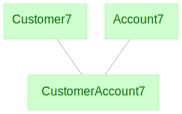

In [9]:
schema7 = dj.Schema('bank7')

@schema7
class Customer7(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    """

@schema7
class Account7(dj.Manual):
    definition = """
    account_id : int unsigned
    ---
    open_date : date
    """

@schema7
class CustomerAccount7(dj.Manual):
    definition = """
    -> Customer7
    -> Account7
    """

dj.Diagram(schema7)

DataJoint’s diagramming language does not use special notation for association tables; they appear identical to other tables.
By contrast, other diagramming styles, such as **Chen’s Entity-Relationship (ER) notation**, represent associations—often called "relationship sets"—with diamond shapes to distinguish them from entity sets.

DataJoint purposefully avoids this strict conceptual distinction between entities and relationships, as the boundary between them is often blurred.
For instance, a synapse between two neurons could be considered an entity, storing specific data about the synapse itself, or it might be viewed as an association linking two neurons.
Additionally, some relationships can even link other relationships, a complexity not easily captured in Chen’s notation.

In DataJoint, you can often recognize an association table by its converging pattern of foreign keys, which reference multiple tables to form a many-to-many relationship. This flexible approach supports various interpretations of relationships, making DataJoint schemas particularly adaptable for complex scientific data, where associations may themselves hold meaningful attributes.

Association tables are primarily used to establish many-to-many relationships, but they also offer the flexibility to model one-to-many and even one-to-one relationships by applying additional uniqueness constraints. By controlling the uniqueness on the foreign keys within the association table, you can fine-tune the type of relationship between entities.

### Example, enforcing One-to-Many with Shared Accounts 

In the following example, we model a scenario where each customer can have only one account, but each account may be shared among multiple customers.
This structure enforces a one-to-many relationship between `Customer8` and `Account8` via the `CustomerAccount8` association table.

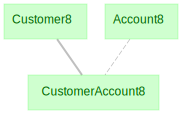

In [10]:
schema8 = dj.Schema('bank8')

@schema8
class Customer8(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    """

@schema8
class Account8(dj.Manual):
    definition = """
    account_id : int unsigned
    ---
    open_date : date
    """

@schema8
class CustomerAccount8(dj.Manual):
    definition = """
    -> Customer8
    ---
    -> Account8
    """

dj.Diagram(schema8)

### Explanation of the Design
* **Association Table (`CustomerAccount8`)**: The `CustomerAccount8` association table links `Customer8` and `Account8` through foreign keys. Although it resembles a many-to-many structure, by making the foreign key `-> Customer8` unique (it's the primary key), we ensure that each customer is associated with only one account. However, we leave the `-> Account8` foreign key unconstrained, allowing multiple customers to link to the same account, which enables account sharing.

## Versatility of Association Tables
While association tables are necessary for modeling many-to-many relationships, they can also model one-to-many and even one-to-one relationships.

This is accomplished by by altering their primary key or adding additional uniqueness constraints. If the association table links tables `A` and `B`, then:

* One-to-Many: 

```
-> B
--- 
-> A
```

Any number of `B`s are each matched to at most one `A`.


* One-to-One: 
```
-> A
---
-> [unique] B
```

With uniqueness constraints on both `A` and `B`, each entry in `A` is matched to at most one entry in `B` and vice versa.

* Many-to-Many

```
-> A
-> B
---
```
 Leave both foreign keys in the primary key, allowing each entity to associate freely with multiple instances of the other.

This approach makes association tables a powerful tool for defining relationships of varying cardinality, adding flexibility and adaptability to DataJoint schemas. By managing uniqueness constraints directly in the association table, you can model complex relationships while keeping the primary entities’ structures simple and intuitive.

The schema diagram indicates the cardinality of these associations with thick lines corresponding to one-to-one relationship and thin lines indicating one-to-many:

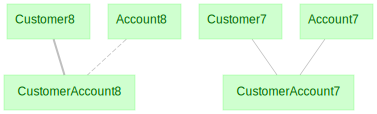

In [11]:
dj.Diagram(schema7) + dj.Diagram(schema8)

# More Design Patterns

Here we will consider several other common patterns that make use of uniqueness constraints (primary keys and unique indexes) and referential constraints (foreign keys) to design more complex relationships.

## Sequences

DataJoint schemas are directional: dependencies form a *directed-acyclic graph* (DAG) representing sequences of steps or operations.
The diagrams are plotted with all the dependencies pointing in the same direction (top-to-bottom or left-to-right), so that a schema diagram can be understood as an operational workflow.

Let's model a simple sequence of operations such as placing an order, shipping, and delivery.
The three entities: `Order`, `Shipment`, and `Delivery` form a sequence of one-to-one relationships:

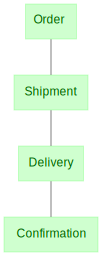

In [13]:
schema = dj.Schema('orders')

@schema
class Order(dj.Manual):
    definition = """
    order_number : int
    ---
    order_date : date
    """

@schema
class Shipment(dj.Manual):
    definition = """
    -> Order
    ---
    ship_date : date
    """


@schema
class Delivery(dj.Manual):
    definition = """
    -> Shipment
    ---
    delivery_date : date
    """

@schema
class Confirmation(dj.Manual):
    definition = """
    -> Delivery
    ---
    confirmation_date : date
    """


dj.Diagram(schema)

In this design, `Order`, `Shipment`, `Delivery`, and `Confirmation` use the same primary key that cascades through the sequence. This makes it straightforward to perform relationonal operations that skip steps. For example, joining information from `Order` and `Confirmation` does not require the inclusion of `Shipment` and `Deliverty` in the query: `Order * Confirmation` is a well-formed query:

In [14]:
Order * Confirmation

order_number,order_date,confirmation_date


## Hierarchies

Several 1:N relationships in sequence form a *hierarchy*. Many data standards are defined as hierarchies.

Filesystems of files and folders with standardized naming conventions are examples of hierarchical structures. Many file formats such as HDF5 are also hierarchical.

### Example: Brain Imaging Database 

Consider the hierarchical structure of the *[Brain Imaging Data Standard](https://bids.neuroimaging.io/)* — [@10.1038/sdata.2016.44], which is used for brain imaging data.

In BIDS, a neuroimaging study is organized around experiment subjects, imaging sessions for each subject, and then specific types of brain scans within each session: anatomical scans, diffusion-weighted imaging (DWI) scans, and functional imaging.

The hierarchy `Study` → `Subject` → `Session` → `Func` represents this organization, where:
- Each study has multiple subjects
- Each subject has multiple imaging sessions  
- Each session contains multiple functional imaging scans

This is a classic hierarchical design where the primary key cascades through the foreign keys. Notice that the primary key of `Func` contains four attributes: `study`, `subject_id`, `session`, and `func`. This allows direct joins between any tables in the hierarchy without requiring intermediate tables.

Let's design a relational schema for the BIDS hierarchical format:

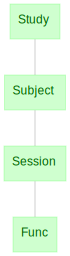

In [ ]:
schema = dj.Schema('bids')

@schema
class Study(dj.Manual):
    definition = """
    study : varchar(6)  # study unique code
    ---
    investigator : varchar(60)  # primary investigator
    study_description : varchar(255)
    """

@schema
class Subject(dj.Manual):
    definition = """
    -> Study
    subject_id  : varchar(8)
    ---  
    subject_species : enum('human', 'primate', 'rodent')
    date_of_birth = null : date
    subject_notes : varchar(2000)
    """

@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session  : smallint unsigned
    ---  
    session_date : date
    operator : varchar(60)
    aim : varchar(255)
    """

@schema
class Func(dj.Manual):
    definition = """
    -> Session
    func  : smallint unsigned
    ---  
    func_filepath : varchar(255)
    scan_params : varchar(500)
    """

dj.Diagram(schema)

### Key Features of Hierarchical Design

In this hierarchical design:

* **Cascading Primary Keys**: The primary key from `Study` propagates all the way down to `Func`, creating solid lines in the diagram. This is indicated by the solid (not dashed) connections.

* **Direct Joins**: Because the primary keys cascade, you can join any two tables in the hierarchy directly. For example, `Study * Func` is a valid join that doesn't require including `Subject` or `Session` in the query.

* **One-to-Many at Each Level**: Each foreign key creates a one-to-many relationship:
  - One study has many subjects
  - One subject has many sessions
  - One session has many functional scans

* **Composite Primary Keys**: Lower tables have composite primary keys that include all ancestor identifiers. For example, a functional scan is uniquely identified by `(study, subject_id, session, func)`.

This design pattern is extremely common in scientific workflows and hierarchical data organization systems.


# Parameterization

The parameterization pattern is used when you want to apply different methods, algorithms, or parameters to the same set of entities. This creates a many-to-many relationship, but the association table itself becomes the entity of interest.

## Example: Image Enhancement

Consider a system where you have images and want to apply various enhancement methods to them:


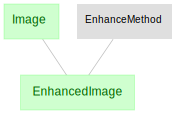

In [ ]:
schema9 = dj.Schema('params')

@schema9
class Image(dj.Manual):
    definition = """
    image_id : int
    ---
    image : longblob  # image data
    """

@schema9
class EnhanceMethod(dj.Lookup):
    definition = """
    enhance_method : int
    ---
    method_name : varchar(16)
    method_description : varchar(255)
    """
    contents = [
        (1, 'sharpen', 'Sharpen edges in the image'),
        (2, 'contrast', 'Increase contrast'),
        (3, 'denoise', 'Remove noise from image')
    ]

@schema9
class EnhancedImage(dj.Manual):
    definition = """
    -> Image
    -> EnhanceMethod
    ---
    enhanced_image : longblob
    processing_timestamp : timestamp
    """

dj.Diagram(schema9)

### Understanding the Parameterization Pattern

In this design:

* **`Image`**: Stores the original images, each with a unique ID
* **`EnhanceMethod`**: A lookup table defining available enhancement methods
* **`EnhancedImage`**: The association table that stores the results of applying each method to each image

The key feature is that `EnhancedImage` has a **composite primary key** consisting of both `image_id` and `enhance_method`. This allows:
- The same image to be processed with multiple enhancement methods
- The same enhancement method to be applied to multiple images
- Each combination is stored as a unique result

This pattern is called "parameterization" because you're essentially parameterizing the Image entity by the EnhanceMethod. The `EnhancedImage` table is the entity of primary interest—it contains the actual processed results.

**Design Choice**: Because both foreign keys are part of the primary key, this creates a many-to-many relationship. If you moved `EnhanceMethod` below the line (as a secondary attribute), each image could only be enhanced using one method.

# Directed Graphs

Directed graphs represent relationships where there is a directional connection between nodes. In databases, this often appears when entities of the same type can be related to each other in a specific direction.

Common examples include:
- Employees and their managers (both are employees)
- Neurons and synapses (connections between neurons)
- Social media follows (users following other users)
- File systems (folders containing other folders)

## Example: Neural Connectivity

In neuroscience, we often need to model connections between neurons. Each synapse is a directed connection from a presynaptic neuron to a postsynaptic neuron:

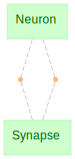

In [ ]:
schema10 = dj.Schema('neuro')

@schema10
class Neuron(dj.Manual):
    definition = """
    neuron_id : int
    ---
    neuron_type : enum('excitatory', 'inhibitory')
    layer : int
    """

@schema10
class Synapse(dj.Manual):
    definition = """
    synapse_id : int
    ---
    -> Neuron.proj(presynaptic='neuron_id')
    -> Neuron.proj(postsynaptic='neuron_id')
    strength : float  # synaptic weight
    """

dj.Diagram(schema10)

### Key Features of Directed Graphs

In this neural connectivity example:

* **Acyclic Dependencies**: The `Synapse` table references the `Neuron` table twice, creating connections between neurons without the need for a cyclic dependency (Neuron -> Synapse -> Neuron).
* **Renamed foreign keys**: We use `.proj()` to rename the foreign keys to `presynaptic` and `postsynaptic`, making the relationship clear
* **Multigraph**: Multiple synapses can connect the same pair of neurons (since `synapse_id` is the primary key)
* **Directionality**: The relationship has a clear direction from presynaptic to postsynaptic neuron

## Example: Employee Management Hierarchy

Another common directed graph is an organizational hierarchy where employees report to managers (who are also employees):

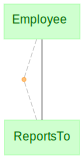

In [19]:
schema11 = dj.Schema('org')

@schema11
class Employee(dj.Manual):
    definition = """
    employee_id : int
    ---
    full_name : varchar(60)
    hire_date : date
    """

@schema11
class ReportsTo(dj.Manual):
    definition = """
    -> Employee
    ---
    -> Employee.proj(manager_id='employee_id')
    """

dj.Diagram(schema11)

In this organizational hierarchy:

* **`Employee`** is the base entity table containing all employees
* **`ReportsTo`** creates the management relationships, where:
  - The primary key is `employee_id` (the subordinate)
  - The foreign key references `manager_id` (also an employee)
* **One manager, many reports**: Each employee reports to exactly one manager (or none if they're the CEO), but one manager can have many direct reports

**Why not a self-referencing foreign key?** In classical SQL design, you might add a `manager_id` column directly to the `Employee` table. In DataJoint, we avoid self-referencing tables to maintain the acyclic property of the schema. Instead, we create a separate association table. This also makes it easier to:
- Add attributes to the relationship (e.g., start date of reporting relationship)
- Query the reporting structure
- Handle employees without managers (no nullable foreign keys in primary keys)

# Design Puzzle: States, Cities, and Capitals

Here's an interesting design challenge that combines one-to-many relationships with additional uniqueness constraints:

**Requirements:**
1. Each city belongs to exactly one state
2. Each state has exactly one capital city
3. A capital must be a city
4. A capital must be in the same state

This is a classic puzzle in database design that's similar to modeling teams and team captains. Let's explore the solution:

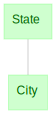

In [ ]:
schema12 = dj.Schema('geography')

@schema12
class State(dj.Manual):
    definition = """
    state : char(2)  # two-letter state code
    ---
    state_name : varchar(30)
    """

@schema12
class City(dj.Manual):
    definition = """
    -> State
    city_name : varchar(30)
    ---
    capital = null : enum('YES')
    unique index(state, capital)
    """

dj.Diagram(schema12)

### Understanding the Solution

This design elegantly handles all four requirements:

1. **Cities belong to states**: The foreign key `-> State` in the `City` table's primary key ensures each city belongs to exactly one state

2. **Unique capitals**: The `unique index(state, capital)` constraint ensures that for each state, there can be at most one city with `capital='YES'`

3. **Capitals are cities**: Since the capital designation is just an attribute of the `City` table, capitals are by definition cities

4. **Capitals in the same state**: The `state` field is part of both the foreign key and the unique index, ensuring the capital must be in that state

**The Key Insight**: The nullable enum field `capital = null : enum('YES')` combined with `unique index(state, capital)` is the clever trick. Since the unique index only applies to non-null values, you can have multiple cities with `capital=null` in the same state, but only one city can have `capital='YES'` for each state.

This is the same pattern you would use for modeling teams and team captains, where:
- `State` → `Team`
- `City` → `Player`
- `capital='YES'` → `is_captain='YES'`

## Summary

We've explored several key relationship patterns:

* **One-to-Many**: Using foreign keys in secondary attributes (dashed lines) or using foreign keys in a composite primary key (solid thin lines). Or use an association table with a unique constraint on one of the foreign keys.
* **One-to-One**: Using foreign keys as primary keys (thick solid lines) or in secondary attributes with unique constraints (thin dashed lines)  
* **Many-to-Many**: Using association tables with composite primary keys
* **Sequences**: Cascading one-to-one relationships for workflows
* **Hierarchies**: Cascading one-to-many relationships with expanding primary keys
* **Parameterization**: Association tables where the association itself is the entity of interest
* **Directed Graphs**: Self-referencing relationships with renamed foreign keys
* **Constrained Relationships**: Using nullable enums with unique indexes for special cases

Understanding these patterns allows you to design schemas that accurately represent complex business rules and data relationships.